In [7]:
%run module.py

In [8]:
# %load module.py
import numpy as np
import random as rand
from matplotlib import pyplot as plt
import math as m
from collections import deque
import heapq
import networkx as nx

def remove_from_list_tuple(l, i):
    """
    Remove the tuple with i as first element from the list of tuples l.
    """
    for item in l:
        if item[0] == i:
            l.remove(item)
            break  
    return l

def generate_random_symetrical_boolean_graph(n):
    """
    Generate a random symetrical graph with n nodes. There is at least one edge between two nodes.
    """
    A = np.random.randint(0, 2, (n, n))
    A = np.triu(A, 1)
    A += A.T  

    if(not connexity(A)):
        A = generate_random_symetrical_boolean_graph(n)

    A_tuple = tuple(map(tuple, A))
    return A_tuple

def generate_random_symetrical_weighted_graph(n, min, max):
    """
    Generate a random symetrical weighted graph with n nodes.
    """
    A = np.random.uniform(min, max, (n, n))
    A = np.triu(A, 1)
    A += A.T  
    A_tuple = tuple(map(tuple, A))
    return A_tuple



def generate_empty_graph(n):
    """
    Generate an empty graph with n nodes.
    """
    A = np.zeros((n, n))
    A_tuple = tuple(map(tuple, A))
    return A_tuple


def connexity(A):
    n = len(A)
    visited = np.zeros(n, dtype=bool)
    stack = [0] 
    visited[0] = True

    while stack:
        node = stack.pop()
        neighbors = np.nonzero(A[node])[0]
        for i in neighbors:
            if not visited[i]:
                stack.append(i)
                visited[i] = True

    return np.all(visited)


def generate_random_collect_points(cities):
    """
    Generate a random list of cities where the vehicle will collect the packages.
    """
    collect_points = np.random.randint(0, 2, cities)
    return collect_points



def generate_random_delivery_requests(cities, collect_points):
    """
    Generate a random list of cities where the vehicle will deliver the packages.
    """
    drop_points = []
    for i in range(len(collect_points)):
        if collect_points[i]:
            number_of_drop_points = rand.randint(0, cities - 1)

            for j in range(number_of_drop_points):
                drop_point = rand.randint(0, cities - 1)
                if((i, drop_point) not in drop_points):
                    drop_points.append((i, drop_point))
    return drop_points




def generate_random_delivery_requests_v2(cities, collect_points):

    # Création d'un masque pour les points collectés
    mask = collect_points.astype(bool)

    # Nombre de points de chute pour chaque point collecté
    number_of_drop_points = np.random.randint(0, cities - 1, size=np.sum(mask))

    # Générer les coordonnées des points de chute
    drop_points_indices = np.random.randint(0, cities - 1, size=(np.sum(number_of_drop_points), 2))
    #print(drop_points_indices)

    # Filtrer les doublons
    drop_points = drop_points_indices[~np.isin(drop_points_indices[:, 0], np.where(mask)[0])]
    #print(drop_points)

    # Créer un array de tuples
    drop_points = np.array([(point, drop) for point, drop in drop_points])
    return drop_points




def C(A, phi, Temp, i, j, t, amplitude, offset, frequency):
    """
    Cost function between the cities i and j at time t.

    @param A: Graph of the cities.
    @param phi: Initial phases
    @param Temp: Initial values to simulate randomness.
    @param i: City of departure.
    @param j: City of arrival.
    @param t: Time.
    @param amplitude: Amplitude of the cost function.
    @param offset: Offset of the cost function.
    @param frequency: Frequency of the cost function.
    """
    return max(0, round((amplitude * m.sin(frequency * t + phi[i][j]) + offset) * Temp[i][j]), 4) if A[i][j] == 1 else float('inf')



def neighbors(A, i):
    """
    Return the neighbors of the city i in the graph A.
    """
    return [j for j in range(len(A[i])) if A[i][j] == 1]



def pass_through(A, i, j):
    """"
    Mark the edge between the cities i and j as passed through.
    """
    A[i][j] = 1
    A[j][i] = 1



def collect(P, r):
    """
    Mark the object m from the request r as collected.
    """
    P[r[0]][r[1]] = 1



def deliver(D, r):
    """
    Mark the object m from the request r as delivered.
    """
    D[r[0]][r[1]] = 1



def get_city_passed_through(X, t):
    """
    Get the city passed through at time t.
    """
    for i in range(len(X[t])):
        for j in range(len(X[t][i])):
            if X[t][i][j]:
                return i, j



def AStar(A, start, end, t, phi, Temp, amplitude, offset, frequency):

    n = len(A)
    open_list = []
    heapq.heappush(open_list, (0, start))
    closed_list = set()
    g = np.full(n, float('inf'))
    g[start] = 0
    f = np.full(n, float('inf'))
    f[start] = 0

    parent = np.full(n, None)

    cost_cache = {}

    # Cache the cost function
    def cost(i, j, t):
        if (i, j, t) not in cost_cache:
            cost_cache[(i, j, t)] = C(A, phi, Temp, i, j, t, amplitude, offset, frequency)
        return cost_cache[(i, j, t)]
    
    while open_list:
        _, i = heapq.heappop(open_list)

        if i in closed_list:
            continue
        closed_list.add(i)

        if i == end:
            path = [end]
            while parent[path[0]] is not None:
                path.insert(0, parent[path[0]])
            return path
        
        for j in neighbors(A, i):
            if j not in closed_list:
                try_g = g[i] + cost(i, j, t)
                if try_g < g[j]:
                    g[j] = try_g
                    f[j] = g[j] + cost(j, end, t)
                    parent[j] = i
                    t += 1
                    heapq.heappush(open_list, (f[j], j))
    return None



def construct_path(solution):
    """
    Construct the path from the solution (list of tuples (i, j) where i is the city of departure and j the city of arrival).
    """
    path = [solution[0][0]]
    for i, j in solution:
        path.append(j)
    return path

def check_delivery_done(D, R):
    """
    Check if all the deliveries have been done.
    """
    for i in range(len(D)):
        for j in range(len(D[i])):
            if D[i][j] == 1 and (i, j) in R:
                return False
    return True

def generate_random_solution(A, R):
    """
    Generate a random solution for the problem.
    """
    X = []
    p = []
    d = []

    s0 = rand.randint(0, len(A) - 1)
    X.append(generate_empty_graph(len(A)))
    
    

    
def draw_graph(A):
    """
    Draw the graph A.
    """
    G = nx.Graph()
    for i in range(len(A)):
        for j in range(len(A[i])):
            if A[i][j] == 1:
                G.add_edge(i, j)
    nx.draw(G, with_labels=True)
    plt.show()

def draw_markov_chain(A):
    """
    Draw the Markov chain A.
    """
    G = nx.DiGraph()
    for i in range(len(A)):
        for j in range(len(A[i])):
            if A[i][j] > 0:
                G.add_edge(i, j, weight=A[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.show()

def draw_graph_and_path(A, path):
    """
    Draw the graph A with the path.
    """
    G = nx.Graph()
    for i in range(len(A)):
        for j in range(len(A[i])):
            if A[i][j] == 1:
                G.add_edge(i, j)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)

    # Draw in green the first city
    first_city = path.index(True)
    nx.draw_networkx_nodes(G, pos, nodelist=[first_city], node_color='g')

    for i in range(len(path) - 1):
        if path[i]:
            nx.draw_networkx_edges(G, pos, edgelist=[(i, i + 1)], edge_color='r')
    plt.show()




def plot_graph(A, weights=None):
    """
    Plot the graph A.
    """
    plt.figure()
    plt.imshow(A, cmap='gray')
    plt.axis('off')
    plt.show()
    if weights is not None:
        print(weights)

    

In [9]:
city_list = [
    "New York", "Los Angeles", "Chicago", "Houston", "Phoenix",
    "Philadelphia", "San Antonio", "San Diego", "Dallas", "San Jose",
    "Austin", "Jacksonville", "Fort Worth", "Columbus", "Charlotte",
    "San Francisco", "Indianapolis", "Seattle", "Denver", "Washington"
]

In [10]:
def generate_random_city_links(cities: list, oriented = True):
    """
    Generate a random adjacency matrix

    Parameters
    ----------
    cities : list
        a list of city names that will represent each vertex
        
    oriented : bool, optional
        Whether or not the graph should be oriented. If True, the graph is oriented 
        (the adjacency matrix is not necessarily symmetrical). Default is True.

    Returns
    -------
    type : list
        a random adjacency matrix
    """
    
    adjacency_matrix = []

    if (oriented):
        for i in range(len(cities)):
            adjacency_matrix.append([rand.randint(0, 1) if i != j else 0 for j in range(len(cities))])
        return adjacency_matrix
    
    for i in range(len(cities)):
        
        adjacency_matrix.append(
                [adjacency_matrix[j][i] for j in range(i)] +
                [0] +
                [rand.randint(0, 1) if i != j else 0 for j in range(len(cities) - i - 1)]
        )
        
    return adjacency_matrix

random_cities_adjacency_matrix = generate_random_city_links(city_list)
np.array(random_cities_adjacency_matrix)

for random_cities_adjacency_matrix_line in random_cities_adjacency_matrix:
    print(random_cities_adjacency_matrix_line)

[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0]
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1]
[0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]
[1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1]
[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]
[1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]
[1, 0, 1, 0, 0, 0, 0, 0,

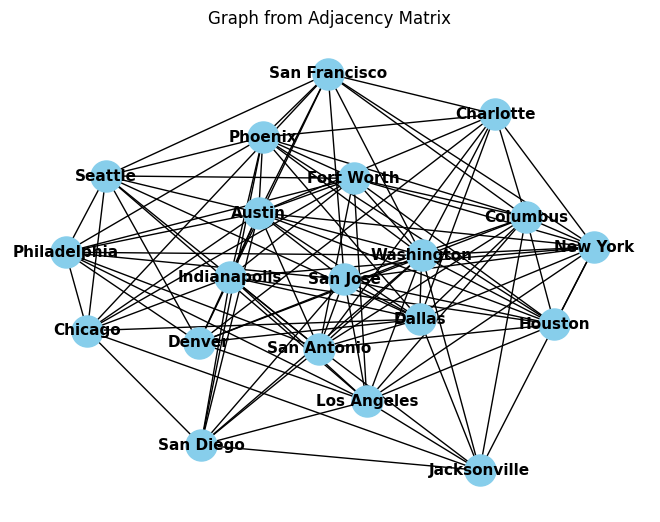

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(vertices, adjacency_matrix):
    G = nx.Graph()

    # Add vertices to the graph
    for vertex in vertices:
        G.add_node(vertex)

    # Add edges to the graph based on the adjacency matrix
    num_vertices = len(vertices)
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(vertices[i], vertices[j])
    
    return G

def draw_graph(G):
    
    pos = nx.spring_layout(G)  # Positions nodes using Fruchterman-Reingold force-directed algorithm
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=11, font_weight='bold')
    plt.title("Graph from Adjacency Matrix")
    plt.show()
    
G = create_graph(city_list, random_cities_adjacency_matrix)

draw_graph(G)    

In [12]:
def is_connected(graph):
    """
    Check if a graph is connected using depth-first search (DFS).

    Parameters:
    graph (nx.Graph): The graph object.

    Returns:
    bool: True if the graph is connected, False otherwise.
    """
    # Perform DFS traversal starting from an arbitrary node
    visited = set()
    start_node = next(iter(graph.nodes()))  # Get the first node in the graph
    dfs(graph, start_node, visited)

    # Check if all nodes have been visited
    return len(visited) == len(graph.nodes())

def dfs(graph, node, visited):
    """
    Perform depth-first search (DFS) traversal on the graph.

    Parameters:
    graph (nx.Graph): The graph object.
    node: The current node in the traversal.
    visited (set): A set to track visited nodes.

    Returns:
    None
    """
    visited.add(node)
    for neighbor in graph.neighbors(node):
        if neighbor not in visited:
            dfs(graph, neighbor, visited)

print("Is the graph connected?", is_connected(G))

Is the graph connected? True


In [13]:
def create_random_incomplete_oriented_graph(cities, edge_prob):
    # Create a directed graph
    G = nx.DiGraph()
    G.add_nodes_from(cities)
    
    # Add edges with a given probability
    for i in cities:
        for j in cities:
            if i != j and rand.random() < edge_prob:
                # Add an edge with a random weight
                G.add_edge(i, j, weight=rand.randint(1, 10))
    
    return G

In [14]:
def find_random_solution(adjacency_matrix):
    unique_cities = len(adjacency_matrix[0])
    unique_cities_visited = []
    chain = []

    departure_city = rand.choice(range(0, unique_cities))
    current_city = departure_city
    
    chain.append(departure_city)

    # 
    
    while (len(unique_cities_visited) != unique_cities):
        
        linked_cities = [index for index, value in enumerate(adjacency_matrix[current_city]) if value == 1]
        
        if not linked_cities:
            raise ValueError("No linked city...")
            
        random_linked_city = get_random_linked_city(linked_cities, unique_cities_visited)
        
        if (random_linked_city not in unique_cities_visited):
            unique_cities_visited.append(random_linked_city)
                
        current_city = random_linked_city
        chain.append(current_city)
        
        
    while (True):
        
        linked_cities = [index for index, value in enumerate(adjacency_matrix[current_city]) if value == 1]

        if not linked_cities:
            raise ValueError("No linked city...")
        
        if departure_city in linked_cities:
            chain.append(departure_city)
            break
        
        random_linked_city = rand.choice(linked_cities)
        current_city = random_linked_city
        chain.append(current_city)
        
    return chain

def get_random_linked_city(linked_cities: list, unique_cities_visited: list):
    
    linked_cities_to_chose_from = linked_cities
    random_linked_city = 0
    
    for i in range(len(linked_cities)):
            
        random_linked_city = rand.choice(linked_cities_to_chose_from)
        linked_cities_to_chose_from.remove(random_linked_city)
        
        if (random_linked_city not in unique_cities_visited):
            return random_linked_city

    return random_linked_city

random_solution = find_random_solution(random_cities_adjacency_matrix)
print(random_solution)
print(len(random_solution))

[2, 12, 17, 10, 5, 1, 7, 9, 3, 16, 14, 15, 19, 11, 13, 0, 8, 2, 15, 4, 17, 18, 6, 2]
24


In [15]:
G = create_random_incomplete_oriented_graph(range(1000), 0.5)

#shortest_paths = dict(nx.floyd_warshall(G))

In [16]:
shortest_paths = dict(nx.floyd_warshall(G))

KeyboardInterrupt: 

In [33]:
def generate_random_deliveries(objects, G, prob: float):
    deliveries = dict()
    for i in G.nodes():
        if rand.random() <= prob:
            deliveries[i] = rand.choice(objects)
    return deliveries
            
def generate_random_depots(G, prob: float):
    depots = []
    for i in G.nodes():
        if rand.random() <= prob:
            depots.append(i)
    return depots

def find_random_solution_vrppd(graph, depots, deliveries, home_depot=None):
    if home_depot is None:
        home_depot = rand.choice(list(graph.nodes()))
    
    current_location = home_depot
    chain = [current_location]
    depots_left_to_visit = depots[:]
    
    while deliveries or current_location != home_depot:
        neighbors = list(graph.neighbors(current_location))
        rand.shuffle(neighbors)
        moved = False
        
        for neighbor in neighbors:
            if neighbor in deliveries and deliveries[neighbor] not in depots_left_to_visit:
                del deliveries[neighbor]
                next_location = neighbor
                moved = True
                break
            if neighbor in depots_left_to_visit:
                depots_left_to_visit.remove(neighbor)
                next_location = neighbor
                moved = True
                break
        
        if not moved:
            next_location = rand.choice(neighbors)
        
        chain.append(next_location)
        current_location = next_location
    
    return chain

def is_vrppd_solution_valid(chain, depots, deliveries, graph):
    # Check if the solution starts and ends at the home depot
    if chain[0] != chain[-1]:
        return False
    
    # Check if all depots and deliveries are visited
    depots_set = set(depots)
    deliveries_set = set(deliveries.keys())
    visited_depots = set()
    visited_deliveries = set()
    previous_location = None
    
    for location in chain[::-1]:
        
        if previous_location is not None and previous_location not in list(graph.neighbors(location)):
            return False
        
        if location in depots_set:
            if (sum(1 for key in visited_deliveries if visited_deliveries[key] == location) != sum(1 for key in deliveries_set if deliveries_set[key] == location)):
                return False
            visited_depots.add(location)
        if location in deliveries_set:
            visited_deliveries.add(location)
            
        previous_location = location
    
    # Check if all depots and deliveries were visited
    if visited_depots != depots_set or visited_deliveries != deliveries_set:
        return False
    
    return True
        
random_depots = generate_random_depots(G, 0.1)
random_deliveries = generate_random_deliveries(random_depots, G, 0.8)

print(random_depots)
print(random_deliveries)

random_solution_vrppd = find_random_solution_vrppd(G, random_depots, random_deliveries)

print(random_solution_vrppd)

print(is_vrppd_solution_valid(random_solution_vrppd, random_depots, random_deliveries, G))

[7, 17, 18, 28, 32, 39, 48, 65, 74, 89, 98, 107, 122, 139, 144, 146, 152, 173, 177, 178, 188, 194, 203, 207, 224, 225, 232, 233, 240, 242, 247, 251, 252, 258, 267, 271, 320, 324, 334, 361, 374, 386, 388, 421, 425, 427, 434, 461, 471, 472, 476, 487, 499, 512, 514, 519, 544, 545, 567, 574, 586, 605, 619, 623, 631, 642, 658, 661, 662, 668, 679, 682, 685, 691, 696, 704, 706, 712, 713, 717, 718, 738, 741, 763, 775, 783, 789, 796, 806, 818, 821, 831, 837, 839, 846, 857, 858, 864, 875, 876, 898, 901, 917, 922, 928, 933, 937, 941, 954, 957, 962, 989, 990]
{0: 713, 1: 957, 2: 122, 3: 224, 4: 928, 6: 65, 7: 858, 8: 783, 9: 763, 10: 990, 11: 514, 12: 937, 17: 98, 18: 194, 19: 17, 20: 806, 21: 188, 22: 623, 23: 796, 24: 173, 25: 386, 26: 857, 27: 658, 28: 741, 29: 718, 30: 574, 32: 544, 33: 188, 34: 789, 35: 18, 37: 107, 38: 17, 39: 232, 41: 374, 44: 619, 45: 858, 46: 258, 47: 334, 48: 642, 49: 631, 50: 928, 51: 32, 52: 471, 53: 679, 55: 858, 56: 685, 57: 605, 58: 17, 59: 831, 60: 837, 63: 271, 64

In [ ]:
def decay_law(T: float):
    return 0.99 * T
    
def get_random_neighbour(solution: list, city_list: list):
    
    perturbated_solution = solution[:]
    
    i, j = rand.sample(range(len(perturbated_solution)), 2)
    perturbated_solution[i], perturbated_solution[j] = perturbated_solution[j], perturbated_solution[i]

# Get all pairs shortest paths using Floyd-Warshall algorithm
shortest_paths = dict(nx.floyd_warshall(G))

print(shortest_paths)

def generate_complete_graph(graph, shortest_paths):
    
    # Iterate over all pairs of nodes
    for u in graph.nodes():
        for v in graph.nodes():
            if u != v and not graph.has_edge(u, v):
                # Add edge with the shortest path distance
                graph.add_edge(u, v, weight=shortest_paths[u][v])
    
    return graph

generated_complete_graph = generate_complete_graph(G, shortest_paths)

def get_solution_cost(shortest_paths, current_solution: list):
    cost = 0
    for i in current_solution[:-1]:
        cost += shortest_paths[city_list[i]][city_list[i + 1]]
    return

print(get_solution_cost(shortest_paths, random_solution))

def simulated_annealing(decay_law: callable, s0: list, city_list: list, T0: float, get_random_neighbour: callable, shortest_paths):
    T = T0
    current_solution = s0
    current_solution_cost = get_solution_cost(shortest_paths, current_solution)
    
    while T > 0:
        
        random_neighbour = get_random_neighbour(current_solution, city_list)
        random_neighbour_cost = get_solution_cost(shortest_paths, random_neighbour)
        
        if (
            random_neighbour_cost <= current_solution_cost
            or
            rand.random() <= m.exp(-(random_neighbour_cost - current_solution_cost)/T)
        ):
            current_solution = random_neighbour
            current_solution_cost = random_neighbour_cost
        
        T = decay_law(T)
        
    return current_solution

optimized_solution = simulated_annealing(decay_law, random_solution, city_list, 200, get_random_neighbour, G)

print(optimized_solution)

{'New York': defaultdict(<function floyd_warshall_predecessor_and_distance.<locals>.<lambda>.<locals>.<lambda> at 0x0000027B299F0A40>, {'New York': 0, 'Chicago': 2, 'Houston': 4, 'Phoenix': 4, 'Dallas': 1, 'San Jose': 3, 'Austin': 3, 'Jacksonville': 5, 'Fort Worth': 4, 'Charlotte': 6, 'Indianapolis': 5, 'Denver': 2, 'Los Angeles': 5, 'Philadelphia': 8, 'San Antonio': 3, 'San Diego': 4, 'Columbus': 5, 'San Francisco': 7, 'Seattle': 6, 'Washington': 5}), 'Los Angeles': defaultdict(<function floyd_warshall_predecessor_and_distance.<locals>.<lambda>.<locals>.<lambda> at 0x0000027B1892A2A0>, {'Los Angeles': 0, 'Phoenix': 3, 'Philadelphia': 8, 'San Antonio': 2, 'San Diego': 4, 'Jacksonville': 5, 'Fort Worth': 6, 'San Francisco': 5, 'Denver': 2, 'New York': 5, 'Chicago': 7, 'Houston': 7, 'Dallas': 3, 'San Jose': 3, 'Austin': 6, 'Columbus': 7, 'Charlotte': 8, 'Indianapolis': 6, 'Seattle': 6, 'Washington': 5}), 'Chicago': defaultdict(<function floyd_warshall_predecessor_and_distance.<locals>.<l

IndexError: list index out of range